## Feature Extraction: Under the hood

In [19]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt

## Orginial Signal

In [20]:
sample_rate, signal = scipy.io.wavfile.read('../../../Source/Clean_train_clips/Shuffle/1/1.wav')  


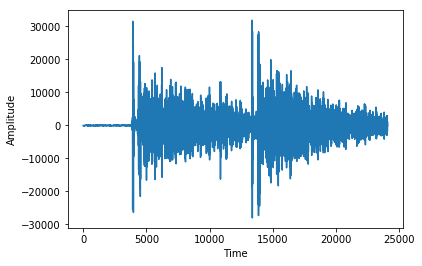

In [25]:
plt.plot(signal)
plt.xlabel('Time')
plt.ylabel('Amplitude');

## Pre-emphasis filter

In [40]:
pre_emphasis = 0.97 # Typically 0.95 or 0.97 for Automatic Speech Recognition (ASR)

In [41]:
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

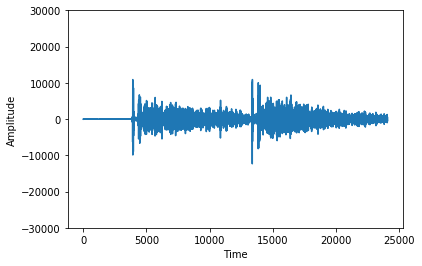

In [44]:
plt.plot(emphasized_signal)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.ylim(-30000, 30000);

## Framing

In [45]:
frame_size = 0.025 # 25 msec (Typically 20-40 msec for ASR)
frame_stride = 0.010 # 10 msec with 15 msec overlap (Typically 50% overlap)


In [86]:
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

In [87]:
frames.shape

(53, 1102)

## Apply (Hamming) window function to each frame

In [83]:
frames *= np.hamming(frame_length)

In [115]:
#frames

## Fourier Transform and Power Spectrum

In [98]:
NFFT = 512 # Typically 256 or 512

In [102]:
mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

In [107]:
mag_frames.shape

(53, 257)

In [108]:
pow_frames.shape

(53, 257)

## Filter Banks

In [109]:
nfilt = 40

In [110]:
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate) # floor rounds to the nearest int

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

In [112]:
filter_banks.shape

(53, 40)

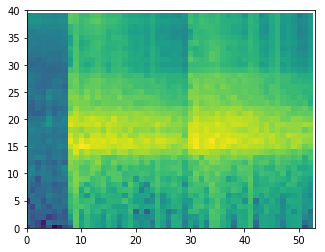

In [140]:
plt.imshow(filter_banks.T) # I don't know how to really plot this!
plt.xlim(0,53)
plt.ylim(0,40);


## Mel-frequency Cepstral Coefficients (MFCCs)

In [136]:
num_ceps = 12

In [137]:
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

In [139]:
mfcc.shape

(53, 12)

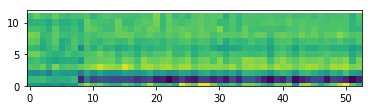

In [146]:
plt.imshow(mfcc.T) # I don't know how to really plot this!
plt.ylim(0,12);


## Mean Normalization

In [147]:
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

In [149]:
# filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

In [151]:
mfcc.shape

(53, 12)